## Iniciar Bibliotecas

In [176]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [177]:
def load_dataframe():
    """
    Carrega o dataset de diabetes do arquivo CSV.
    Retorna:
        DataFrame pandas contendo os dados do dataset
    """
    if not os.path.exists("data"):
        print("O diretório data não foi encontrado.")
    df = pd.read_csv("data/diabetes.csv")
    return df

In [178]:
def save_output(df, filename):
    """
    Salva um DataFrame em um arquivo CSV na pasta output.
    Args:
        df: DataFrame a ser salvo
        filename: Nome do arquivo (sem extensão)
    """
    if not os.path.exists("output"):
        os.makedirs("output")
    df.to_csv(f"output/{filename}.csv", index=False)
    print(f"Arquivo salvo em output/{filename}.csv")

In [179]:
def remove_outliers_iqr(df, columns):
    """
    Remove outliers do dataset usando o método IQR.
    Args:
            df: DataFrame contendo os dados
            columns: Lista de colunas para remover outliers
    Returns:
            DataFrame com outliers removidos
    """
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[
            (df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)
        ]
    return df_clean

In [180]:
def summary_statistics(df):
    """
    Gera estatísticas descritivas do dataset.
    Mostra estatísticas básicas, informações do dataset e contagem de valores nulos.
    Args:
            df: DataFrame contendo os dados
    """
    print("\n=== Estatísticas Descritivas ===")
    print("\nEstatísticas básicas:")
    print(df.describe())

    print("\nInformações do dataset:")
    print(df.info())

    print("\nValores nulos por coluna:")
    print(df.isnull().sum())

In [181]:
def analyze_distributions(df):
    """
    Analisa e plota as distribuições de todas as variáveis do dataset.
    Cria histogramas com KDE (Kernel Density Estimation) para cada variável.
    Args:
        df: DataFrame contendo os dados
    """
    print("\n=== Análise de Distribuições ===")

    # Configurar o estilo dos gráficos
    plt.style.use("seaborn-v0_8")

    # Criar subplots para cada variável
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle("Distribuição das Variáveis", fontsize=16)

    # Converte array 2D para 1D
    axes = axes.ravel()

    # Plotar histograma e KDE para cada variável
    for idx, column in enumerate(df.columns):
        sns.histplot(data=df, x=column, kde=True, ax=axes[idx])
        axes[idx].set_title(f"Distribuição de {column}")
        axes[idx].set_xlabel(column)
        axes[idx].set_ylabel("Frequência")

In [182]:
def analyze_correlations(df):
    """
    Analisa e plota as correlações entre as variáveis do dataset.
    Cria um mapa de calor (heatmap) com as correlações e mostra as correlações mais fortes.
    Args:
            df: DataFrame contendo os dados
    """
    print("\n=== Análise de Correlações ===")

    # Calcular matriz de correlação
    corr_matrix = df.corr()

    # Plotar mapa de calor
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
    plt.title("Matriz de Correlação")
    plt.tight_layout()
    if not os.path.exists("output"):
        os.makedirs("output")
    plt.savefig("output/correlations.png")
    plt.close()

    # Mostrar correlações mais fortes
    print("\nCorrelações mais fortes:")
    corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
    print(corr_pairs[corr_pairs != 1.0].head(10))

In [183]:
def detect_outliers(df):
    """
    Detecta e analisa outliers no dataset usando o método IQR (Interquartile Range).
    Cria boxplots para cada variável e mostra estatísticas dos outliers.
    Args:
            df: DataFrame contendo os dados
    """
    print("\n=== Análise de Outliers ===")

    # Configurar o estilo dos gráficos
    plt.style.use("seaborn-v0_8")

    # Criar boxplots para cada variável
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle("Boxplots para Detecção de Outliers", fontsize=16)

    # Flatten axes para facilitar o loop
    axes = axes.ravel()

    # Plotar boxplot para cada variável
    for idx, column in enumerate(df.columns):
        sns.boxplot(data=df, y=column, ax=axes[idx])
        axes[idx].set_title(f"Boxplot de {column}")

    plt.tight_layout()
    if not os.path.exists("output"):
        os.makedirs("output")
    plt.savefig("output/outliers.png")
    plt.close()

    # Análise estatística de outliers usando IQR
    # IQR (Interquartile Range) é a diferença entre o terceiro quartil (Q3) e o primeiro quartil (Q1).
    # Ele é usado para identificar a dispersão central dos dados e detectar outliers.

    print("\nEstatísticas de Outliers (método IQR):")
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        if len(outliers) > 0:
            print(f"\n{column}:")
            print(f"Número de outliers: {len(outliers)}")
            print(f"Limites: [{lower_bound:.2f}, {upper_bound:.2f}]")
            print(f"Valores dos outliers: {outliers[column].values}")

In [184]:
def prepare_data(df):
    """
    Prepara e limpa os dados para modelagem.
    Realiza as seguintes etapas:
    1. Trata valores zero inválidos
    2. Remove linhas com valores ausentes
    3. Normaliza variáveis numéricas
    4. Remove outliers
    Args:
            df: DataFrame contendo os dados
    Returns:
            DataFrame limpo e preparado
    """
    print("\n=== Limpeza e Preparação dos Dados ===")
    df_clean = df.copy()

    # 1. Tratar valores ausentes ou inválidos
    cols_with_zero_invalid = [
        "Glucose",
        "BloodPressure",
        "SkinThickness",
        "Insulin",
        "BMI",
    ]
    for col in cols_with_zero_invalid:
        num_zeros = (df_clean[col] == 0).sum()
        if num_zeros > 0:
            print(f"Coluna {col}: {num_zeros} valores zero substituídos por NaN")
            df_clean[col] = df_clean[col].replace(0, np.nan)

    # 2. Remove linhas com valores ausentes
    df_clean = df_clean.dropna()

    # 3. Normaliza variáveis numéricas (exceto Outcome)
    features = df_clean.columns.drop("Outcome")
    scaler = StandardScaler()
    df_clean[features] = scaler.fit_transform(df_clean[features])
    print("Variáveis numéricas normalizadas (StandardScaler).")

    # 4. Remove outliers
    df_clean = remove_outliers_iqr(df_clean, features)
    print("Outliers removidos usando método IQR.")

    return df_clean

In [185]:
def feature_engineering(df):
	"""
	Realiza engenharia de características no dataset.
	Inclui:
	1. Seleção de features baseada em correlação
	2. Criação de features de interação
	3. Categorização de variáveis
	4. One-hot encoding
	Args:
		df: DataFrame contendo os dados
	Returns:
		DataFrame com novas features
	"""
	print("\n=== Engenharia de Características ===")
	df_eng = df.copy()

	# 1. Análise de correlações com variáveis numéricas
	print("\nCorrelação com a variável alvo (Outcome):")
	correlations = df_eng.corr()['Outcome'].sort_values(ascending=False)
	print(correlations)

	threshold = 0.1 # Correlação mínima para manter a feature
	selected_features = correlations[abs(correlations) > threshold].index.tolist()
	selected_features.remove('Outcome') # Remove a variável alvo da lista

	print(f"\nFeatures selecionadas (correlação > {threshold}):")
	print(selected_features)

	# 2. Criar features de interação
	if all(col in df_eng.columns for col in ['BMI', 'Age']):
		df_eng['BMI_Age'] = df_eng['BMI'] * df_eng['Age']
		print("\nFeature de interação criada: BMI_Age")

	if all(col in df_eng.columns for col in ['Glucose', 'Insulin']):
		df_eng['Glucose_Insulin_Ratio'] = df_eng['Glucose'] / df_eng['Insulin']
		print("\nFeature de interação criada: Glucose_Insulin_Ratio")

	# 3. Criar variáveis categóricas
	df_eng['BMI_Category'] = pd.cut(df_eng['BMI'], 
		bins=[0, 18.5, 25, 30, 100],
		labels=['abaixo do peso', 'normal', 'sobrepeso', 'obeso'])

	df_eng['Age_Group'] = pd.cut(df_eng['Age'],
		bins=[0, 30, 45, 60, 100],
		labels=['jovem', 'adulto', 'senhor', 'idoso'])

	df_eng['Glucose_Level'] = pd.cut(df_eng['Glucose'],
		bins=[0, 100, 125, 300],
		labels=['normal', 'prediabetes', 'diabetes'])

	# 4. One-hot encoding para variáveis categóricas
	categorical_cols = ['BMI_Category', 'Age_Group', 'Glucose_Level']
	df_eng = pd.get_dummies(df_eng, columns=categorical_cols, drop_first=True)
	
	print("\nNovas features criadas:")
	print(df_eng.columns.tolist())
	
	return df_eng


In [186]:
def balance_classes(df):
	"""
	Balanceia as classes do dataset usando undersampling.
	Args:
		df: DataFrame contendo os dados
	Returns:
		DataFrame com classes balanceadas
	"""
	print("\n=== Análise e Balanceamento de Classes ===")
	
	# Mostrar distribuição original
	class_counts = df['Outcome'].value_counts()
	print("\nDistribuição original das classes:")
	print(f"Classe 0 (Sem diabetes): {class_counts[0]} ({class_counts[0]/len(df)*100:.1f}%)")
	print(f"Classe 1 (Com diabetes): {class_counts[1]} ({class_counts[1]/len(df)*100:.1f}%)")
	
	# Aplicar undersampling
	print("\nAplicando balanceamento de classes...")
	min_class = df[df['Outcome'] == df['Outcome'].value_counts().idxmin()]
	maj_class = df[df['Outcome'] == df['Outcome'].value_counts().idxmax()]
	
	# Amostrar aleatoriamente da classe majoritária
	maj_class_sampled = maj_class.sample(n=len(min_class), random_state=42)
	
	# Combinar as classes
	df_balanced = pd.concat([min_class, maj_class_sampled])
	
	# Mostrar nova distribuição
	new_class_counts = df_balanced['Outcome'].value_counts()
	print("\nNova distribuição após balanceamento:")
	print(f"Classe 0 (Sem diabetes): {new_class_counts[0]} ({new_class_counts[0]/len(df_balanced)*100:.1f}%)")
	print(f"Classe 1 (Com diabetes): {new_class_counts[1]} ({new_class_counts[1]/len(df_balanced)*100:.1f}%)")
	
	return df_balanced

In [187]:
def process_training_data(df):
    df_train = df.copy()
    
    X = df_train.drop('Outcome', axis=1)
    y = df['Outcome']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print("\nFormato dos dados:")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test
    
    

## Cria os modelos (Artificial Neural Network e Random Forest)

In [188]:
def create_model_rna(input_dim):
    model = Sequential()
    input_dim = int(input_dim)

    model.add(Input(shape=(input_dim,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [189]:
def create_model_random_forest(X_train, y_train, n_estimators=100, max_depth=None, random_state=42):
    model = RandomForestClassifier(
        n_estimators=n_estimators,  
        max_depth=max_depth,
        random_state=random_state,
        class_weight='balanced'
    )
    
    model.fit(X_train, y_train)
    
    return model

## Executa os testes para gerar Acurácia, Precisão, Recall, F1-Score e Curva ROC.

In [190]:
def evaluate_model(model, X_test, y_test, threshold = 0.5):
    is_keras = hasattr(model, "evaluate")
    
    if is_keras:
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        y_pred_prob = model.predict(X_test)
    else:
        loss = None
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        accuracy = accuracy_score(y_test, (y_pred_prob > threshold).astype(int))
    
     # Gerar classificações binárias com base no threshold
    y_pred = (y_pred_prob > threshold).astype(int)
    
    # Gerar as Métricas do modelo
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    #Curva de ROC
    false_positive, true_positive, thresholds = roc_curve(y_test, y_pred_prob)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    model_statistics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1_score': f1,
        'roc_curve': (false_positive, true_positive, thresholds),
        'auc': auc_score,
        'confusion_matrix': cm
    }
    
    return model_statistics
    

# Plotar dados

Esta área serve para organizar a criação dos PLOT nescessários para serem exibidos.

In [191]:
def plot_roc_curve(fpr, tpr, auc_score):
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend()
    plt.grid(True)
    plt.show()

In [192]:
def plot_training_history(historic):
    plt.figure(figsize=(12, 5))  # aumenta o tamanho do gráfico
    
    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(historic.history['accuracy'], label='Treinamento', color='blue')
    plt.plot(historic.history['val_accuracy'], label='Validação', color='orange')
    plt.title('Evolução da Acurácia por Época', fontsize=14)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Acurácia', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Gráfico de Perda (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(historic.history['loss'], label='Treinamento', color='green')
    plt.plot(historic.history['val_loss'], label='Validação', color='red')
    plt.title('Evolução da Perda (Loss) por Época', fontsize=14)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Perda (Loss)', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [193]:
def plot_confusion_matrix(cm, classes=['Negativo', 'Positivo']):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title("Matriz de Confusão - RNA", fontsize=14)
    plt.xlabel("Classe Predita", fontsize=12)
    plt.ylabel("Classe Real", fontsize=12)
    plt.grid(False)
    plt.show()

# Código organizado
Executar o preparo dos dados.

In [194]:
def prepare_data_pipeline(df):
     # Análise exploratória
    summary_statistics(df)
    analyze_distributions(df)
    analyze_correlations(df)
    detect_outliers(df)

    # Preparação dos dados
    df_clean = prepare_data(df)
    df_eng = feature_engineering(df_clean)
    df_balanced = balance_classes(df_eng)
    
    return df_balanced, df_clean, df_eng


## Executa a Avaliação dos modelos

In [195]:
def run_rna_model_evaluation(X_train, X_test, y_train, y_test):
    model = create_model_rna(input_dim=X_train.shape[1])
    historic = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))
    
    model_statistics = evaluate_model(model, X_test, y_test, threshold=0.5)
    
    fpr, tpr, _ = model_statistics['roc_curve']
    auc = model_statistics['auc']
    cm = model_statistics['confusion_matrix']
    
    # Exibir resultados do modelo RNA
    print("\nResultados do RNA:")
    print(f"Acurácia: {model_statistics['accuracy']:.4f}")
    print(f"Perda: {model_statistics['loss']:.4f}")
    print(f"Precisão: {model_statistics['precision']:.4f}")
    print(f"Recall: {model_statistics['recall']:.4f}")
    print(f"F1-Score: {model_statistics['f1_score']:.4f}")
    print(f"Auc-ROC: {auc:.4f}")
    print(f"Matrix de confusão: {cm}")
    
   
    plot_roc_curve(fpr, tpr, auc)
    plot_training_history(historic)
    plot_confusion_matrix(cm)
    

In [196]:
def run_random_forest_evaluation(X_train, X_test, y_train, y_test):
    model = create_model_random_forest(X_train, y_train)
    
    
    model_statistics = evaluate_model(model, X_test, y_test, threshold=0.5)
    
    fpr, tpr, _ = model_statistics['roc_curve']
    auc = model_statistics['auc']
    cm = model_statistics['confusion_matrix']
    
    # Exibir resultados do modelo Random Forest
    print("\nResultados do Random Forest:")
    print(f"Acurácia: {model_statistics['accuracy']:.4f}")
    print(f"Precisão: {model_statistics['precision']:.4f}")
    print(f"Recall: {model_statistics['recall']:.4f}")
    print(f"F1-Score: {model_statistics['f1_score']:.4f}")
    print(f"Auc-ROC: {auc:.4f}")
    print(f"Matrix de confusão: {cm}")
    
    
    plot_roc_curve(fpr, tpr, auc)
    plot_confusion_matrix(cm)
    
    
    


=== Estatísticas Descritivas ===

Estatísticas básicas:
       Pregnancies     Glucose  ...         Age     Outcome
count   768.000000  768.000000  ...  768.000000  768.000000
mean      3.845052  120.894531  ...   33.240885    0.348958
std       3.369578   31.972618  ...   11.760232    0.476951
min       0.000000    0.000000  ...   21.000000    0.000000
25%       1.000000   99.000000  ...   24.000000    0.000000
50%       3.000000  117.000000  ...   29.000000    0.000000
75%       6.000000  140.250000  ...   41.000000    1.000000
max      17.000000  199.000000  ...   81.000000    1.000000

[8 rows x 9 columns]

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             7

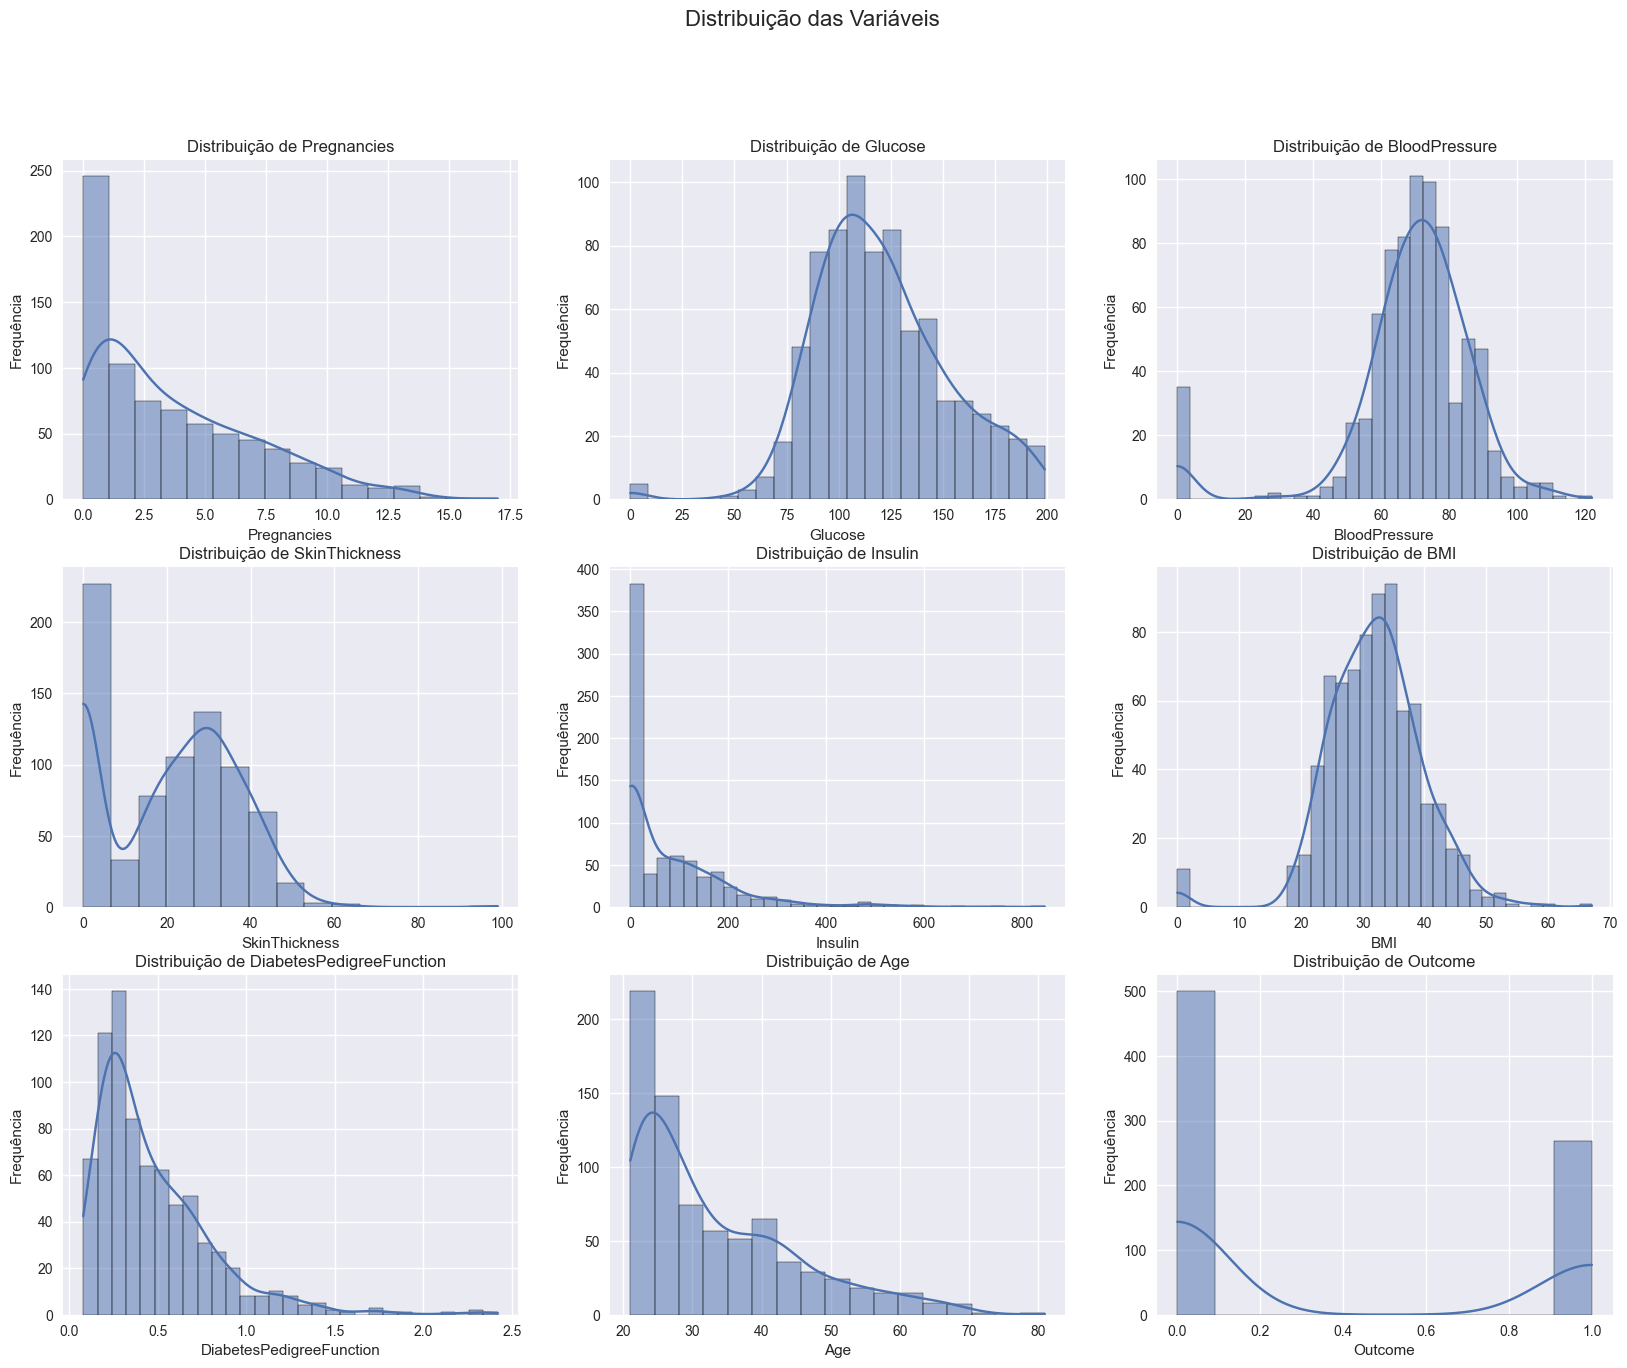

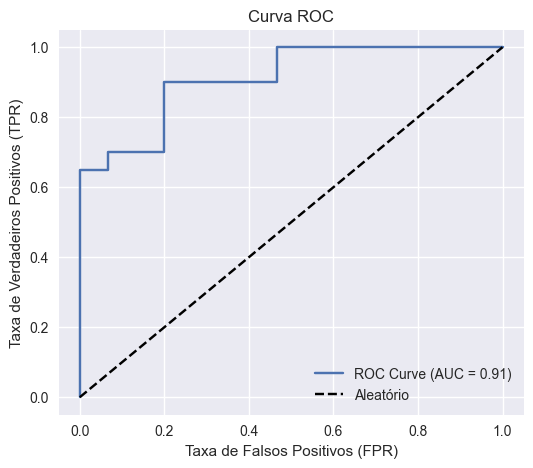

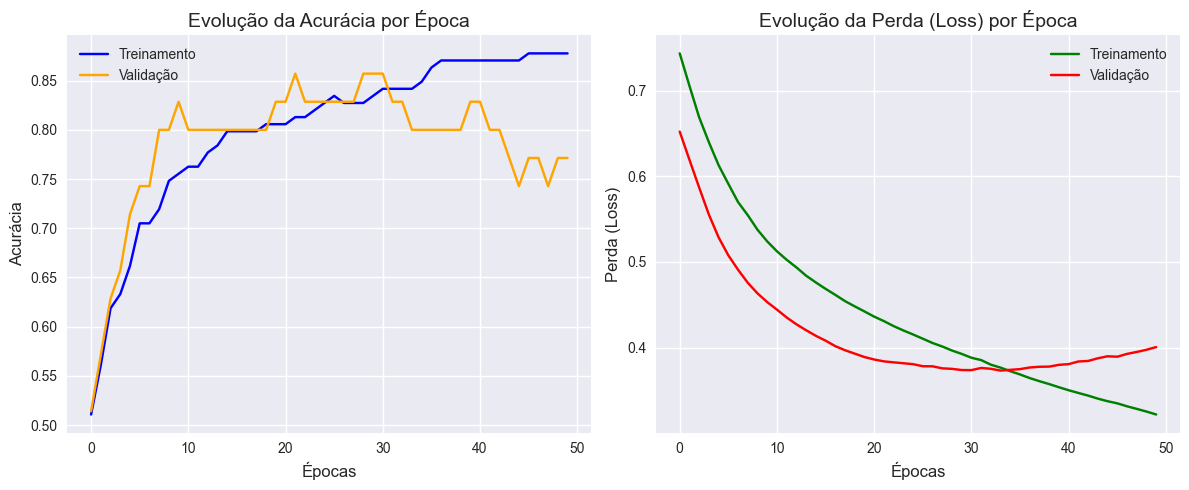

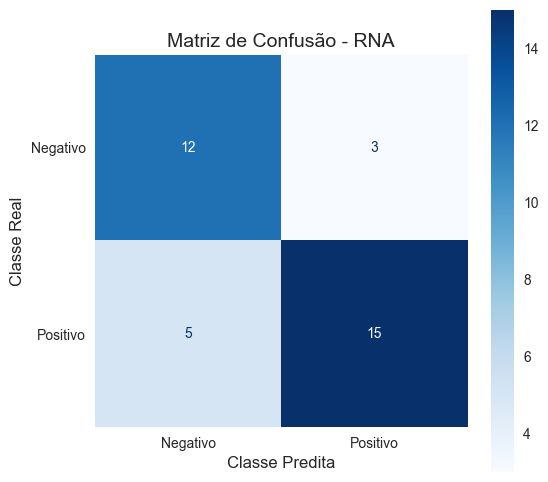


Resultados do Random Forest:
Acurácia: 0.8286
Precisão: 1.0000
Recall: 0.7000
F1-Score: 0.8235
Auc-ROC: 0.8767
Matrix de confusão: [[15  0]
 [ 6 14]]


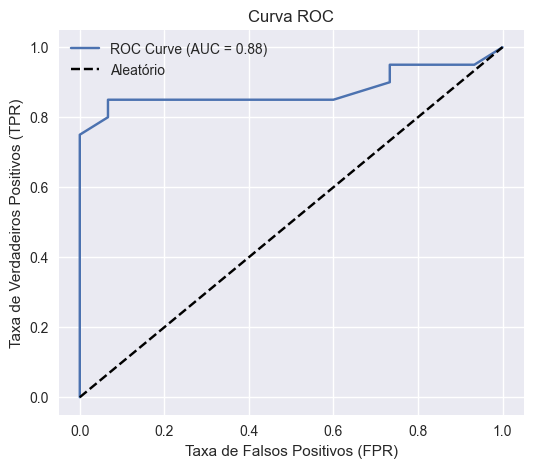

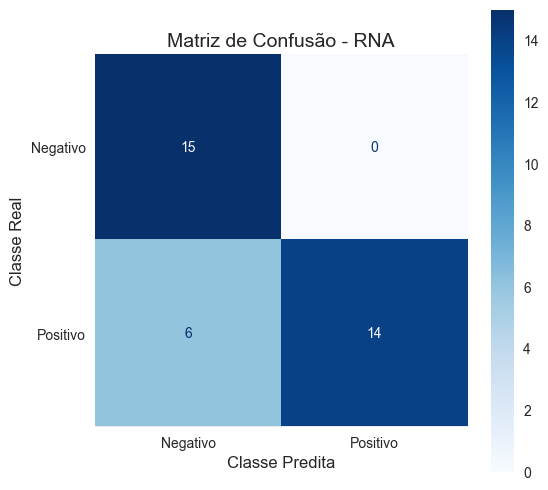

In [197]:
if __name__ == "__main__":
    # Carregar dados
    df = load_dataframe()

    df_balanced, df_train, df_eng = prepare_data_pipeline(df)
    
    X_train, X_test, y_train, y_test = process_training_data(df_balanced)
    run_rna_model_evaluation(X_train, X_test, y_train, y_test)
    run_random_forest_evaluation(X_train, X_test, y_train, y_test)
    
    
    